Let's download the data

In [1]:
import numpy as np
import pandas as pd

# please do not forget to put the file with data ('titanic_data.csv') exactly in the same folder as this notebook
# or you'll have to change your path to data...
train = pd.read_csv('titanic_data.csv')

In [2]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Just as a reminder - an extremely simple baseline model

### A primitive baseline model

In [4]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


The most probably outcome for men - "die"(0), for women - "live" (1). The baseline model is to ascribe the most probable outcome for each man/ woman. This model is correct for 233 women and 468 men. The total accuracy is (233+468)/891 = 78.676%.

### Feature Preprocessing and Missing Values

In [5]:
# let's log-transform Fare. We add 1 to deal with those who didn't pay at all
# I could try to find the "group" tickets using repeated ticket numbers, but not this time 

train["Fare"] = np.log(train["Fare"] + 1)

Cabin seems the worst variable - 687 missing. My first reaction was to cast it away. We can hardly impute something reasonable. Then I thought - maybe it was a matter of procedure - rich got more attention while boarding and their cabin number was registered. It could be a "proxy" for passenger's well-being. Then I found this tutorial:

https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish


"Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, let's slice it off."

In [6]:
# borrowed from:
# https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish

def simplify_cabins(df):
    # no docstring or any other comment - I reproduce the function as it was in the above reference
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [7]:
train = simplify_cabins(train)

As the data set is tiny and the most variables are hardly informative, I'll extract one more feature from passenger's names. Of course, names themselves do not help in survival, but if we look closer, we'll see the Titles which reflect socio-cultural status of a person - can this be useful? Let's try! 

In [8]:
# borrowed from:
# https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

import re as re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

train["Title"] = train["Name"].apply(get_title)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [9]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')


In [10]:
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Miss')

In [11]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,186,0
Mr,0,517
Mrs,125,0
Rare,3,20


In [12]:
train[pd.isnull(train['Embarked']) == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.394449,B,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.394449,B,NaN,Mrs


In [13]:
train.loc[[61, 829], "Embarked"] = "S"

Now I can safely drop the useless variables:

In [14]:
train.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

In [15]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,2.110213,N,S,Mr
1,1,1,female,38.0,1,0,4.280593,C,C,Mrs
2,1,3,female,26.0,0,0,2.188856,N,S,Miss
3,1,1,female,35.0,1,0,3.990834,C,S,Mrs
4,0,3,male,35.0,0,0,2.202765,N,S,Mr
5,0,3,male,NaN,0,0,2.246893,N,Q,Mr
6,0,1,male,54.0,0,0,3.967694,E,S,Mr
7,0,3,male,2.0,3,1,3.094446,N,S,Master
8,1,3,female,27.0,0,2,2.495954,N,S,Mrs
9,1,2,female,14.0,1,0,3.436268,N,C,Mrs


Let's introduce one more feature:

In [16]:
train["FamSize"]=train['SibSp'] + train["Parch"] +1

It is a linear combination of two other features which might be a problem, at least in interpreting the importance of various feature. But it may be relevant to survival:

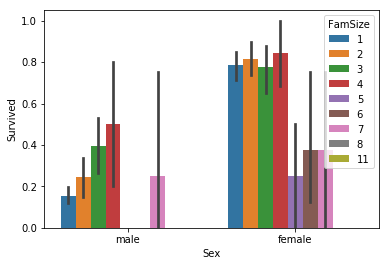

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

sns.barplot(x="Sex", y="Survived", hue="FamSize", data=train)

### Transform categorical variables

In [18]:
def sexConv(s):
    # s is a string with just 2 values - "male" or "female"
    if s == "male":
        return 0
    return 1

In [19]:
train.Sex = train.Sex.apply(lambda ss: sexConv(ss))

In [20]:
train = pd.get_dummies(train, columns = ["Embarked", "Cabin", "Title"])

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Sex             891 non-null int64
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
FamSize         891 non-null int64
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Cabin_A         891 non-null uint8
Cabin_B         891 non-null uint8
Cabin_C         891 non-null uint8
Cabin_D         891 non-null uint8
Cabin_E         891 non-null uint8
Cabin_F         891 non-null uint8
Cabin_G         891 non-null uint8
Cabin_N         891 non-null uint8
Cabin_T         891 non-null uint8
Title_Master    891 non-null uint8
Title_Miss      891 non-null uint8
Title_Mr        891 non-null uint8
Title_Mrs       891 non-null uint8
Title_Rare      891 non-null uint8
dtypes: float64(

### Missing "Age" Values

I am going to use to different strategies:

1. Impute the data using mean and std.dev

2. Transform "Age" into several categories, one of which represents the missing values. The latter approach will miss "order" of age groups as Python has no ordered factor (categorical) variables. This was the reason why I kept "Pclass" as intergers, by the way, rather than transform 1, 2 and 3rd classes in categories.

In [22]:
# I'll need two identical copies of the data set:

train1 = train.copy(deep=True)
train2 = train.copy(deep=True)

In [23]:
train1["Age"] = (train1["Age"] - train1["Age"].mean())/(train1["Age"].std()) 

Here we need a trick.

Problem: If I use train1.fillna(np.random.normal(loc=0.0, scale=1.0)) , it'll call the random generator only once and fill all the missing values with this same value. This is definitely not what I want.


Solution: Instead, I'll first fill all missing "Age" data with some huge number (999999) and then replace it with a random variable - one by one.

In [24]:
def ageConv(a):
    # a is a numeric value or NaN - missing value, replaced by 999999.0
    # returns the same numeric value or generates a random normal value if a was missing the replaced
    if a == 999999.0:
        return np.random.normal(loc=0.0, scale=1.0)
    return a

In [25]:
np.random.seed(1024)
train1.fillna(999999, inplace = True)
train1.Age = train1.Age.apply(lambda x: ageConv(x))
train1.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamSize,Embarked_C,Embarked_Q,...,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,0.014197,0.523008,0.381594,2.962246,1.904602,0.188552,0.086420,...,0.035915,0.014590,0.004489,0.771044,0.001122,0.044893,0.208754,0.580247,0.140292,0.025814
std,0.486592,0.836071,0.477990,0.998723,1.102743,0.806057,0.969048,1.613459,0.391372,0.281141,...,0.186182,0.119973,0.066890,0.420397,0.033501,0.207186,0.406647,0.493796,0.347485,0.158668
min,0.000000,1.000000,0.000000,-3.234246,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,-0.598845,0.000000,0.000000,2.187218,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,-0.048127,0.000000,0.000000,2.737881,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,0.640270,1.000000,0.000000,3.465736,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,3.000000,1.000000,3.462699,8.000000,6.000000,6.240917,11.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Nice. Due to imputation, Age.mean() slightly moved from 0.0, but not much. Age.std() is virtually 1.0

In [26]:
# borrowed from:
# https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish

def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 90)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

In [27]:
train2 = simplify_ages(train2)
train2 = pd.get_dummies(train2, columns = ["Age"])

In [28]:
# Let's check that now there are no missing values

train2.isnull().sum()

Survived           0
Pclass             0
Sex                0
SibSp              0
Parch              0
Fare               0
FamSize            0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Cabin_A            0
Cabin_B            0
Cabin_C            0
Cabin_D            0
Cabin_E            0
Cabin_F            0
Cabin_G            0
Cabin_N            0
Cabin_T            0
Title_Master       0
Title_Miss         0
Title_Mr           0
Title_Mrs          0
Title_Rare         0
Age_Unknown        0
Age_Baby           0
Age_Child          0
Age_Teenager       0
Age_Student        0
Age_Young Adult    0
Age_Adult          0
Age_Senior         0
dtype: int64

In [29]:
train1.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
FamSize         0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Cabin_A         0
Cabin_B         0
Cabin_C         0
Cabin_D         0
Cabin_E         0
Cabin_F         0
Cabin_G         0
Cabin_N         0
Cabin_T         0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
dtype: int64

# Models

### Train/ Test split

Let's start from the simple. Let 20% of the data (both sets) be used as a test. First, the model is trained using a couple of simple algorithms on 80% of data, then the test data might be used to access how good each model is.

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
Train1, Test1 = train_test_split(train1, test_size = 0.2)
Train2, Test2 = train_test_split(train2, test_size = 0.2)

In [32]:
train_labels1 = Train1["Survived"]
train_labels2 = Train2["Survived"]
test_labels1 = Test1["Survived"]
test_labels2 = Test2["Survived"]

In [33]:
train_data1 = Train1.drop("Survived", axis = 1)
train_data2 = Train2.drop("Survived", axis = 1)
test_data1 = Test1.drop("Survived", axis = 1)
test_data2 = Test2.drop("Survived", axis = 1)

In [34]:
from sklearn import linear_model, metrics

I'll start from logistic regression - although it might look old-fahioned. Next, I'll use decision tree. Both algorithms are very simple, but (partly because of their simplicity) can be easily interpreted.

One more thing: sklearn knows nothing of data frames, so they must be transformed into matrices before using in algorithms

In [35]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logistic_regressor.fit(train_data1.as_matrix(), train_labels1)
predTrain1 = logistic_regressor.predict(train_data1.as_matrix())
predTest1 = logistic_regressor.predict(test_data1.as_matrix())

Accuracy for the training set:

In [36]:
metrics.accuracy_score(train_labels1, predTrain1)

0.8412921348314607

Accuracy for the test set:

In [37]:
metrics.accuracy_score(test_labels1, predTest1)

0.8044692737430168

Not bad! It's definitely better than the primitive baseline model (78.7%) I can also extract the parameters of the regression:

In [38]:
logistic_regressor.intercept_ # it is not very informative, of course

array([ 0.4402263])

In [39]:
logistic_regressor.coef_

array([[-0.56221456,  1.46435149, -0.38825588, -0.3870438 , -0.2596485 ,
         0.44529725, -0.206466  ,  0.37149956,  0.12285121, -0.05412447,
         0.05736012,  0.22037968, -0.40258448,  0.41461872,  0.98074326,
         0.23097897, -0.39249054, -0.39437928, -0.27440014,  1.46895166,
         0.07900196, -1.50791427,  1.00231204, -0.60212508]])

This is the real data science! I can see that the large positive coefficient (1.46435) corresponds to "Sex" == 1 (i.e. "Female") - it's not such a big news, however. The array of numbers is pretty difficult to analyse, it badly needs some automatic processing!

In [40]:
feature_importance = logistic_regressor.coef_
feature_list = list(train_data1.columns.values)

for ind in range(len(feature_list)):
    print (str(round(feature_importance[0,ind], 2))+"......."+feature_list[ind] )

-0.56.......Pclass
1.46.......Sex
-0.39.......Age
-0.39.......SibSp
-0.26.......Parch
0.45.......Fare
-0.21.......FamSize
0.37.......Embarked_C
0.12.......Embarked_Q
-0.05.......Embarked_S
0.06.......Cabin_A
0.22.......Cabin_B
-0.4.......Cabin_C
0.41.......Cabin_D
0.98.......Cabin_E
0.23.......Cabin_F
-0.39.......Cabin_G
-0.39.......Cabin_N
-0.27.......Cabin_T
1.47.......Title_Master
0.08.......Title_Miss
-1.51.......Title_Mr
1.0.......Title_Mrs
-0.6.......Title_Rare


Much better! Title_Mr is the most important feature (minus 1.51 - minus means that Mr usually died), the next is Sex (1.46). You may remember from sexConv() function that males were labeled with zeroes  and females with ones. This means that women had much better chances to survive. Title_Master (1.48) also helped to survive. Master was the name for mostly very young boys (although some masters in this data set were 11 or 12 y.o. You can check this using the command train[train["Title"] =="Master"]

As expected, higher Pclass lowered the chances to survive (-0.56), 1st class cabins were for the rich. Similarly, some cabin numbers (E) significantly increased survival rate, while others (C, G and N - unknown) decreased it (cabins for the poor, probably).

In [41]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logistic_regressor.fit(train_data2.as_matrix(), train_labels2)
predTrain2 = logistic_regressor.predict(train_data2.as_matrix())
predTest2 = logistic_regressor.predict(test_data2.as_matrix())

In [42]:
metrics.accuracy_score(train_labels2, predTrain2)

0.8455056179775281

In [43]:
metrics.accuracy_score(test_labels2, predTest2)

0.81564245810055869

In [44]:
feature_importance = logistic_regressor.coef_
feature_list = list(train_data2.columns.values)

for ind in range(len(feature_list)):
    print (str(round(feature_importance[0,ind], 2))+"......."+feature_list[ind] )

-0.63.......Pclass
1.4.......Sex
-0.39.......SibSp
-0.22.......Parch
0.42.......Fare
-0.15.......FamSize
0.35.......Embarked_C
0.4.......Embarked_Q
-0.29.......Embarked_S
0.35.......Cabin_A
0.15.......Cabin_B
-0.38.......Cabin_C
0.05.......Cabin_D
0.46.......Cabin_E
0.27.......Cabin_F
-0.11.......Cabin_G
-0.33.......Cabin_N
0.0.......Cabin_T
1.5.......Title_Master
0.18.......Title_Miss
-1.28.......Title_Mr
0.72.......Title_Mrs
-0.67.......Title_Rare
-0.07.......Age_Unknown
0.94.......Age_Baby
0.21.......Age_Child
0.04.......Age_Teenager
0.04.......Age_Student
0.48.......Age_Young Adult
-0.51.......Age_Adult
-0.68.......Age_Senior


Very similar conclusions to the above. What is new: ages Child and Young_Adult significantly increased survival chance, ages Senior and Adult - decreased.

Let's use decision tree algorithm for the same data.

In [45]:
from sklearn import tree

In [46]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
clfTree.fit(train_data1.as_matrix(), train_labels1)
predTrain1 = clfTree.predict(train_data1.as_matrix())
predTest1 = clfTree.predict(test_data1.as_matrix())

In [47]:
metrics.accuracy_score(train_labels1, predTrain1)

0.8441011235955056

In [48]:
metrics.accuracy_score(test_labels1, predTest1)

0.8044692737430168

In [49]:
clfTree.feature_importances_

array([ 0.13838877,  0.        ,  0.01107914,  0.        ,  0.        ,
        0.05514219,  0.09219251,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.64214728,  0.        ,  0.06105011])

The tree uses several parameters for making a prediction. Others factors are not used (and have zero values for feature importance). Note that the shape of clfTree.feature_importances_ is different from logistic_regressor.coef_. Why? - who knows...

In [50]:
feature_importance = clfTree.feature_importances_
feature_list = list(train_data1.columns.values)

for ind in range(len(feature_list)):
    print (str(round(feature_importance[ind], 2))+"......."+feature_list[ind] )

0.14.......Pclass
0.0.......Sex
0.01.......Age
0.0.......SibSp
0.0.......Parch
0.06.......Fare
0.09.......FamSize
0.0.......Embarked_C
0.0.......Embarked_Q
0.0.......Embarked_S
0.0.......Cabin_A
0.0.......Cabin_B
0.0.......Cabin_C
0.0.......Cabin_D
0.0.......Cabin_E
0.0.......Cabin_F
0.0.......Cabin_G
0.0.......Cabin_N
0.0.......Cabin_T
0.0.......Title_Master
0.0.......Title_Miss
0.64.......Title_Mr
0.0.......Title_Mrs
0.06.......Title_Rare


Interesting! The most important feature is Title_Mr (0.64). The next two features are less important: Pclass (0.14) and FamSize (0.09). These values reflect how often the tree uses the variable to split the data set. What is surprising is that the very simple model produces quite good accuracy - 80.4% for test set.

In [51]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
clfTree.fit(train_data2.as_matrix(), train_labels2)
predTrain2 = clfTree.predict(train_data2.as_matrix())
predTest2 = clfTree.predict(test_data2.as_matrix())

In [52]:
metrics.accuracy_score(train_labels2, predTrain2)

0.8384831460674157

In [53]:
metrics.accuracy_score(test_labels2, predTest2)

0.82681564245810057

In [54]:
feature_importance = clfTree.feature_importances_
feature_list = list(train_data2.columns.values)

for ind in range(len(feature_list)):
    print (str(round(feature_importance[ind], 2))+"......."+feature_list[ind])

0.14.......Pclass
0.0.......Sex
0.0.......SibSp
0.0.......Parch
0.06.......Fare
0.09.......FamSize
0.0.......Embarked_C
0.0.......Embarked_Q
0.0.......Embarked_S
0.0.......Cabin_A
0.0.......Cabin_B
0.0.......Cabin_C
0.0.......Cabin_D
0.0.......Cabin_E
0.0.......Cabin_F
0.0.......Cabin_G
0.0.......Cabin_N
0.0.......Cabin_T
0.0.......Title_Master
0.0.......Title_Miss
0.63.......Title_Mr
0.0.......Title_Mrs
0.07.......Title_Rare
0.0.......Age_Unknown
0.0.......Age_Baby
0.0.......Age_Child
0.0.......Age_Teenager
0.0.......Age_Student
0.0.......Age_Young Adult
0.0.......Age_Adult
0.0.......Age_Senior


Almost the same. Age is ignored, by the way...

Well, let's sum up! It seems that the best accuracy is achieved by decision tree for the data set with categorized Age (82.7%). But can I trust the conclusion? Is the accurcy accessment reliable? Actually, not much. The data set is tiny (891 "observations"). If I leave out 20% for the test set (178 "observations"), the test set is even smaller. So the difference between the best (82.7%) and the worst (80.45%) may be explained by pure chance - the test set better suited some of the algorithms. To tackle the issue, I should use k-fold cross-validation. For k=5, I'll do 5 attempts using 20% of the data as a mock test data set (this set is called "validation set") and build the model using the remaining 80%. In each attempt, I'll use different set of vaues as the validation set. Each "observation" will be used as a test once and for training - 4 times. Finally, I'll get 5 assessment of test accuracy (for validaion sets) which should give me the idea of how much it varies with different data sets used for the testing purpose.

In [55]:
from sklearn import model_selection

In [66]:
train_labs1 = train1["Survived"]
train_labs2 = train2["Survived"]

In [67]:
tr_data1 = train1.drop("Survived", axis = 1)
tr_data2 = train2.drop("Survived", axis = 1)

In [68]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
tree_scoring = model_selection.cross_val_score(clfTree, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 5)


In [69]:
tree_scoring

array([ 0.84357542,  0.79888268,  0.8258427 ,  0.79213483,  0.85310734])

OK. Now I see that accuracy varies from 79.2% to 85.3%. Let's calculate mean and std:

In [70]:
print ('mean: ', tree_scoring.mean(), "  st.deviation: ",  tree_scoring.std())

mean:  0.822708594656   st.deviation:  0.0239656424236


In [71]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
tree_scoring = model_selection.cross_val_score(clfTree, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 5)
print ('mean: ', tree_scoring.mean(), "  st.deviation: ",  tree_scoring.std())

mean:  0.820461332718   st.deviation:  0.0238006768479


In [72]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logR_scoring = model_selection.cross_val_score(logistic_regressor, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 5)
print ('mean: ', logR_scoring.mean(), "  st.deviation: ",  logR_scoring.std())

mean:  0.818239249986   st.deviation:  0.0154906885612


In [73]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logR_scoring = model_selection.cross_val_score(logistic_regressor, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 5)
print ('mean: ', logR_scoring.mean(), "  st.deviation: ",  logR_scoring.std())

mean:  0.814862186399   st.deviation:  0.0173107602296


On average, the better accuracy is achieved by decision tree for data with Age as a float variable (82.3%). Does this conclusion holds for ten-fold cross-validation?

In [74]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logR_scoring = model_selection.cross_val_score(logistic_regressor, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', logR_scoring.mean(), "  st.deviation: ",  logR_scoring.std())

mean:  0.826088695948   st.deviation:  0.0277536819182


In [75]:
logistic_regressor = linear_model.LogisticRegression(random_state = 1)
logR_scoring = model_selection.cross_val_score(logistic_regressor, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', logR_scoring.mean(), "  st.deviation: ",  logR_scoring.std())

mean:  0.816026273976   st.deviation:  0.0309078099138


In [76]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
tree_scoring = model_selection.cross_val_score(clfTree, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', tree_scoring.mean(), "  st.deviation: ",  tree_scoring.std())

mean:  0.813741629781   st.deviation:  0.0281897640888


In [77]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 3, min_samples_leaf = 3)
tree_scoring = model_selection.cross_val_score(clfTree, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', tree_scoring.mean(), "  st.deviation: ",  tree_scoring.std())

mean:  0.826038474634   st.deviation:  0.0289604186034


Now the competition gets really tough! There is no statistically significant winner. The accuracy of 82.6% was achieved by the logistic regression and decision tree - but for different ways of treating the "Age" variable! . By the way, I could hope to improve the decision tree algorithm by playing with its parameters - tree depth (the higher it is, the more complicated patterns it should catch) and minimu size of the leaf (the higher it is, the less over-fitting occurs at the expense of te fact that it catches less details)

In [78]:
clfTree = tree.DecisionTreeClassifier(random_state=1, max_depth = 4, min_samples_leaf = 4)
tree_scoring = model_selection.cross_val_score(clfTree, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', tree_scoring.mean(), "  st.deviation: ",  tree_scoring.std())

mean:  0.826088412212   st.deviation:  0.0286030628109


OK. It turns out that the accuracy of 82.6% can also be achieved for tr_data1 , i.e. for data treating "Age" as a float variable. No improvement for tr_data2. Please note that I don't use default parameters for the tree algorithm. In general, tree-based algorithms usually need parameter fine-tuning for best performance.

The nice feature of sklearn is that you can easily test other classification algorithms - just load its library and fit the model to the data. Let's train several other models and see if any statistically signifiacant improvement of accuracy can be achieved.

In [79]:
# Support Vector Machine with linear kernel
from sklearn import svm

In [80]:
clfSVM = svm.SVC()
svm_scoring = model_selection.cross_val_score(clfSVM, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', svm_scoring.mean(), "  st.deviation: ",  svm_scoring.std())

mean:  0.830533140393   st.deviation:  0.0290239867055


In [81]:
clfSVM = svm.SVC()
svm_scoring = model_selection.cross_val_score(clfSVM, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', svm_scoring.mean(), "  st.deviation: ",  svm_scoring.std())

mean:  0.830533140393   st.deviation:  0.0290239867055


Slightly better

In [82]:
# nearest neighbours
from sklearn import neighbors

In [83]:
knn=neighbors.KNeighborsClassifier()
knn_scoring = model_selection.cross_val_score(knn, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', knn_scoring.mean(), "  st.deviation: ",  knn_scoring.std())

mean:  0.811582113268   st.deviation:  0.0416119702213


In [84]:
knn=neighbors.KNeighborsClassifier()
knn_scoring = model_selection.cross_val_score(knn, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', knn_scoring.mean(), "  st.deviation: ",  knn_scoring.std())

mean:  0.810357791397   st.deviation:  0.0260153665205


It's nothing to speak about.

In [85]:
# also a tree based algorithm - Random Forest!
from sklearn.ensemble import RandomForestClassifier

In [86]:
rf = RandomForestClassifier(n_estimators=50, max_depth=6, min_samples_leaf=3, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.836138633526   st.deviation:  0.0302169819074


In [87]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_leaf=3, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.83390392691   st.deviation:  0.0291340239136


In [88]:
rf = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_leaf=3, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.836188571104   st.deviation:  0.0268284000513


In [89]:
rf = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_leaf=4, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.831656735898   st.deviation:  0.0347272399904


In [90]:
rf = RandomForestClassifier(n_estimators=50, max_depth=6, min_samples_leaf=4, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.832755078879   st.deviation:  0.0324096118693


In [91]:
# OK, this seems to be the best choice of parameters:

rf = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_leaf=3, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.836188571104   st.deviation:  0.0268284000513


In [92]:
# Now let's build the RF for tr_data2

rf = RandomForestClassifier(n_estimators=140, max_depth=7, min_samples_leaf=5, random_state=0)
rf_scoring = model_selection.cross_val_score(rf, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', rf_scoring.mean(), "  st.deviation: ",  rf_scoring.std())

mean:  0.83617608671   st.deviation:  0.0328300490192


Random Forest is definitely better than the two simple models (decision tree and logistic regression), its accuracy is 83.6%. By the way, number of estimators is, in fact, the number of trees which the RF builds to fit the data.

In [93]:
# One more tree-based algorithm which builds new tree so that to compensate for the error produced by the previous tree 
# rather than randomly
from sklearn.ensemble import GradientBoostingClassifier

In [94]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=4, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.835089944388   st.deviation:  0.0417251454983


In [95]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=4, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.831731642265   st.deviation:  0.040751869058


In [96]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=5, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.835115196913   st.deviation:  0.0462143791135


In [97]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=6, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.840720690047   st.deviation:  0.0403507800322


In [98]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=7, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.832880490296   st.deviation:  0.0468253001736


In [99]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=6, max_depth=5, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.823891442515   st.deviation:  0.0453632115591


In [100]:
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=6, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.833941096357   st.deviation:  0.0337408007384


In [101]:
# this seems the best for tr_data1
clfGB = GradientBoostingClassifier(n_estimators=120, learning_rate=0.1, min_samples_leaf=6, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data1.as_matrix(), train_labs1, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.840720690047   st.deviation:  0.0403507800322


In [102]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.844028770855   st.deviation:  0.0411264644909


In [103]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.15, min_samples_leaf=5, max_depth=4, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.836189138577   st.deviation:  0.0374850344436


In [104]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.15, min_samples_leaf=6, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.84291794348   st.deviation:  0.042461498062


In [105]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.15, min_samples_leaf=4, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.838435762116   st.deviation:  0.0475222593565


In [106]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.839546873227   st.deviation:  0.046997391404


In [107]:
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.838461014641   st.deviation:  0.0578832706343


In [108]:
clfGB = GradientBoostingClassifier(n_estimators=150, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.846226024288   st.deviation:  0.0420883620625


In [109]:
clfGB = GradientBoostingClassifier(n_estimators=200, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.837287765293   st.deviation:  0.0457722070294


In [110]:
clfGB = GradientBoostingClassifier(n_estimators=140, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.847362104188   st.deviation:  0.0429689405355


In [111]:
clfGB = GradientBoostingClassifier(n_estimators=130, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.846263761208   st.deviation:  0.0413552503761


In [112]:
# this seems to be the best for tr_data2

clfGB = GradientBoostingClassifier(n_estimators=140, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
gb_scoring = model_selection.cross_val_score(clfGB, tr_data2.as_matrix(), train_labs2, scoring = 'accuracy', cv = 10)
print ('mean: ', gb_scoring.mean(), "  st.deviation: ",  gb_scoring.std())

mean:  0.847362104188   st.deviation:  0.0429689405355


This is the best accuracy (84.7%) so far. What are the most important features for the algorithm?

In [116]:
clfGB = GradientBoostingClassifier(n_estimators=140, learning_rate=0.15, min_samples_leaf=5, max_depth=3, random_state=1)
clfGB.fit(train_data2.as_matrix(), train_labels2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=140, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)

In [117]:
clfGB.feature_importances_

array([ 0.06897209,  0.04465294,  0.03053972,  0.01421999,  0.47677105,
        0.05244117,  0.00941636,  0.01377112,  0.01935555,  0.01332957,
        0.00282104,  0.00897787,  0.00328111,  0.01073351,  0.        ,
        0.        ,  0.01176215,  0.        ,  0.02012341,  0.00937905,
        0.06127334,  0.00791124,  0.01182372,  0.01614527,  0.01089376,
        0.00147694,  0.00948832,  0.02842801,  0.00959619,  0.01405064,
        0.01836487])

In [118]:
feature_list = list(train_data2.columns.values)
feature_importance = clfGB.feature_importances_
for ind in range(len(feature_list)):
    print (str(round(feature_importance[ind], 2))+"......."+feature_list[ind] )

0.07.......Pclass
0.04.......Sex
0.03.......SibSp
0.01.......Parch
0.48.......Fare
0.05.......FamSize
0.01.......Embarked_C
0.01.......Embarked_Q
0.02.......Embarked_S
0.01.......Cabin_A
0.0.......Cabin_B
0.01.......Cabin_C
0.0.......Cabin_D
0.01.......Cabin_E
0.0.......Cabin_F
0.0.......Cabin_G
0.01.......Cabin_N
0.0.......Cabin_T
0.02.......Title_Master
0.01.......Title_Miss
0.06.......Title_Mr
0.01.......Title_Mrs
0.01.......Title_Rare
0.02.......Age_Unknown
0.01.......Age_Baby
0.0.......Age_Child
0.01.......Age_Teenager
0.03.......Age_Student
0.01.......Age_Young Adult
0.01.......Age_Adult
0.02.......Age_Senior


Quite unexpectedly, the most important variable is "Fare"! And accuracy is  84.7%...

Does it mean that I could do better by working more on the "Fare" feature , e.g. select the group tickets and split their value between participating passengers? Possibly.

Another option is to follow strategy "Cluster than Predict"

The baseline model was pretty accurate because the data are easily split into two clusters (Males vsFemakes) with very different behaviour. So it is reasonable to split the train data set into trainM and trainF, then follow the whole programme which I executed here for train and see if there is any improvement in terms of accuracy.

All in all I can clearly state that Gradient Boosting is a very powerful algorithm.